<a href="https://colab.research.google.com/github/aminayusif/Intrudex/blob/main/Intrudex_Cybersecurity_Intrusion_Detection_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

This notebook performs an exploratory data analysis and builds machine learning models to detect cybersecurity intrusions. The analysis includes data preprocessing, feature engineering, handling class imbalance, training and evaluating several supervised learning models (Logistic Regression, Random Forest, Decision Tree, and XGBoost), and applying unsupervised learning techniques (K-Means Clustering and Isolation Forest) for anomaly detection. The goal is to identify patterns associated with malicious activities and build models that can effectively predict potential intrusions.

### Table of Contents

- Data Loading and Initial Exploration
- Data Preprocessing and Feature Engineering
- Handling Class Imbalance
- Supervised Learning Models (Training and Evaluation)
- Unsupervised Learning (K-Means and Isolation Forest)
- Model Interpretation with SHAP
- Summary and Conclusion

#### Data Loading and Initial Exploration

This section covers loading the dataset and performing initial checks such as viewing the head of the dataframe, checking data types and non-null counts, and examining missing values.

#### Data Preprocessing and Feature Engineering

This section details the steps taken to prepare the data for modeling. This includes:
- Dropping irrelevant columns (`session_id`).
- Handling missing values in the `encryption_used` column by imputing with the mode.
- Creating new features such as the `failed_login_ratio`.
- Generating polynomial features (`login_attempts_sq`, `failed_logins_sq`).

#### Handling Class Imbalance

The notebook addresses the class imbalance in the target variable (`attack_detected`) using the Synthetic Minority Over-sampling Technique (SMOTE). Visualizations are included to show the class distribution before and after applying SMOTE.

#### Supervised Learning Models (Training and Evaluation)

This section focuses on building and evaluating supervised learning models:
- The preprocessed and resampled data is split into training and testing sets.
- Logistic Regression, Random Forest, Decision Tree, and XGBoost models are trained and evaluated using GridSearchCV for hyperparameter tuning.
- Performance metrics (accuracy, recall, precision, ROC AUC) are calculated and presented in a table, along with classification reports for each model.
- ROC AUC curves for all models are plotted for visual comparison.

#### Unsupervised Learning (K-Means and Isolation Forest)

This section explores unsupervised learning techniques for anomaly detection:
- K-Means clustering is applied to identify potential groupings in the data, and the Elbow method is used to suggest an optimal number of clusters.
- The clustering results are visualized using scatter plots.
- Isolation Forest is applied to detect anomalies, and the distribution of anomaly scores is visualized.

#### Model Interpretation with SHAP

SHAP (SHapley Additive exPlanations) is used to interpret the Isolation Forest model, providing insights into which features are most influential in determining anomaly scores. A summary plot and a force plot are included to illustrate the SHAP analysis.

#### Summary and Conclusion

This section summarizes the key findings from both the supervised and unsupervised learning analyses, highlighting the performance of the models and insights gained from the data and model interpretation. Possible next steps are also suggested.

## Exploratory data analysis and data preprocessing

### Import common libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load dataset

In [ ]:
data=pd.read_csv('/content/cybersecurity_intrusion_data.csv')

### Inspect dataset

In [ ]:
data.head()

,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           9537 non-null   object 
 1   network_packet_size  9537 non-null   int64  
 2   protocol_type        9537 non-null   object 
 3   login_attempts       9537 non-null   int64  
 4   session_duration     9537 non-null   float64
 5   encryption_used      7571 non-null   object 
 6   ip_reputation_score  9537 non-null   float64
 7   failed_logins        9537 non-null   int64  
 8   browser_type         9537 non-null   object 
 9   unusual_time_access  9537 non-null   int64  
 10  attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 819.7+ KB


Dataset has 11 columns and 9537 rows

Check for null values in dataset

In [ ]:
data.isnull().sum()

,0
session_id,0
network_packet_size,0
protocol_type,0
login_attempts,0
session_duration,0
encryption_used,1966
ip_reputation_score,0
failed_logins,0
browser_type,0
unusual_time_access,0


The column '**encryption used**' has 1966 null values

Let's now get the value counts of the **'encryption used'** column

In [ ]:
print(data['encryption_used'].value_counts(dropna=False))

encryption_used
AES    4706
DES    2865
NaN    1966
Name: count, dtype: int64


Based on the value counts, 'AES' is the most frequent category. Imputing missing values with the mode ('AES') is reasonable given the distribution.

In [ ]:
data['encryption_used'].fillna(data['encryption_used'].mode()[0])
print(data['encryption_used'].value_counts(dropna=False))

encryption_used
AES    4706
DES    2865
NaN    1966
Name: count, dtype: int64


Next, we drop the **session_id** since it serves no function

In [ ]:
data = data.drop('session_id', axis=1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   network_packet_size  9537 non-null   int64  
 1   protocol_type        9537 non-null   object 
 2   login_attempts       9537 non-null   int64  
 3   session_duration     9537 non-null   float64
 4   encryption_used      7571 non-null   object 
 5   ip_reputation_score  9537 non-null   float64
 6   failed_logins        9537 non-null   int64  
 7   browser_type         9537 non-null   object 
 8   unusual_time_access  9537 non-null   int64  
 9   attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 745.2+ KB


### Class distributions

#### Visualize distributions of numerical features

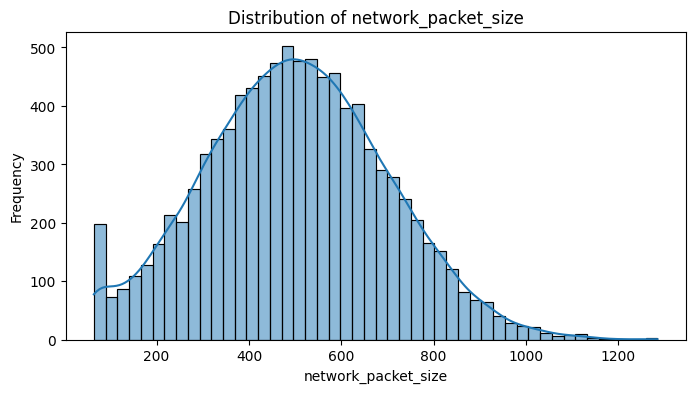

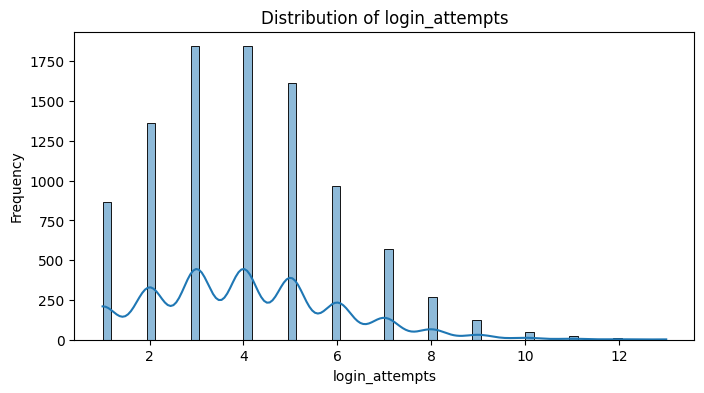

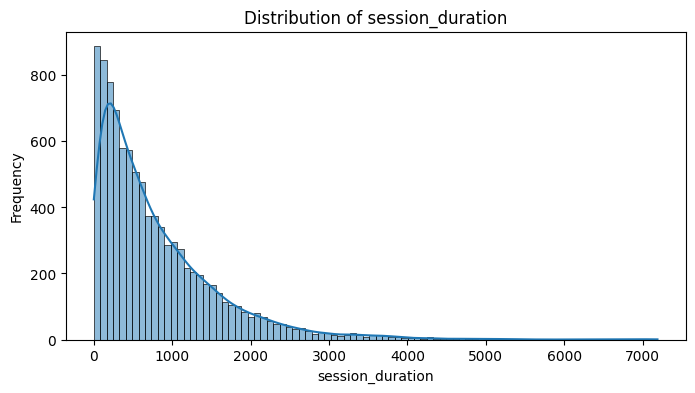

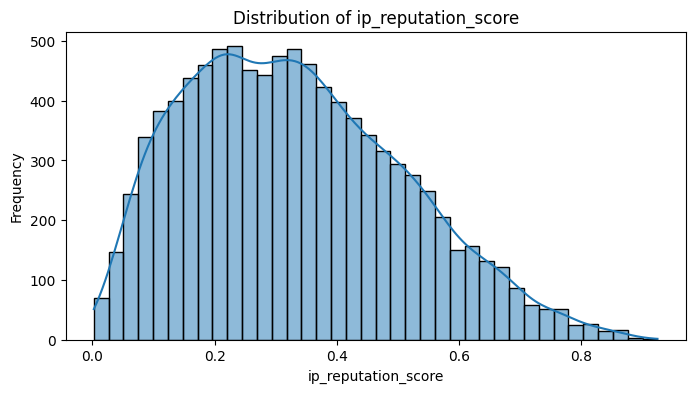

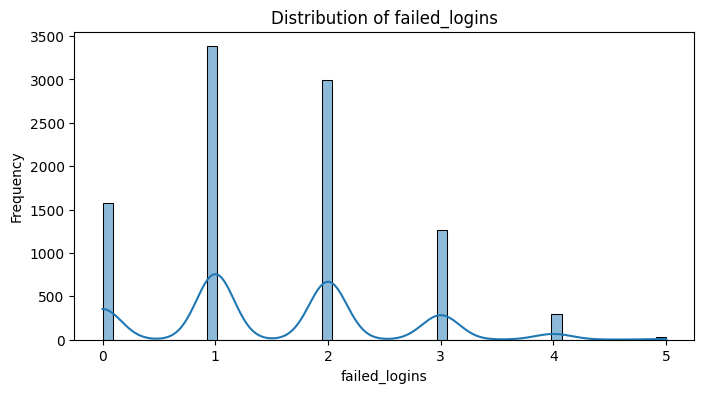

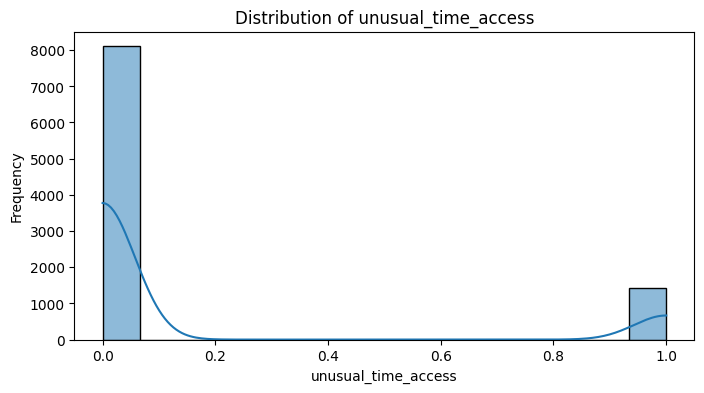

In [ ]:
numerical_features = data.select_dtypes(include=np.number).columns.tolist()
numerical_features.remove('attack_detected') # Exclude the target variable

for feature in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

#### Visualize distributions of categorical features

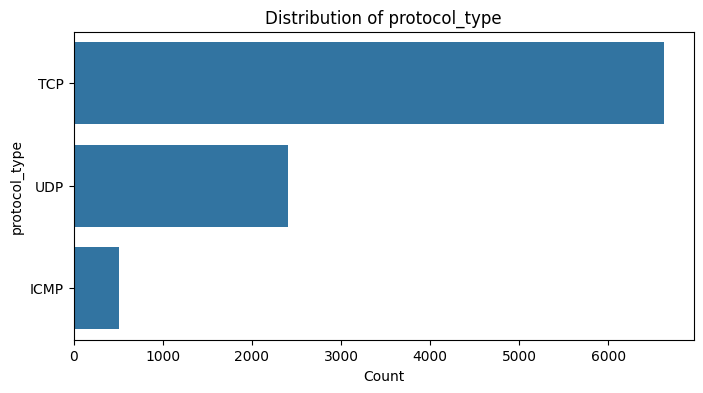

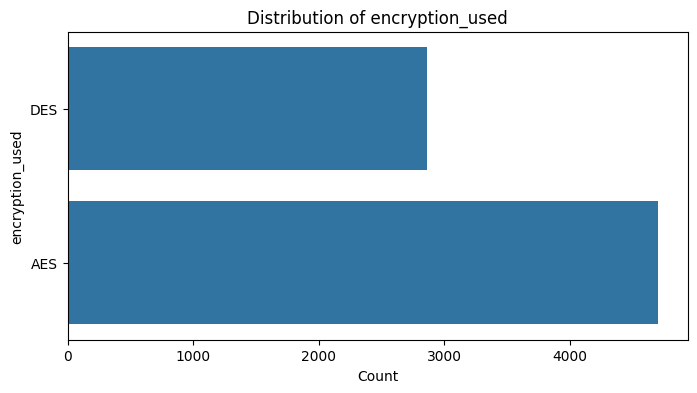

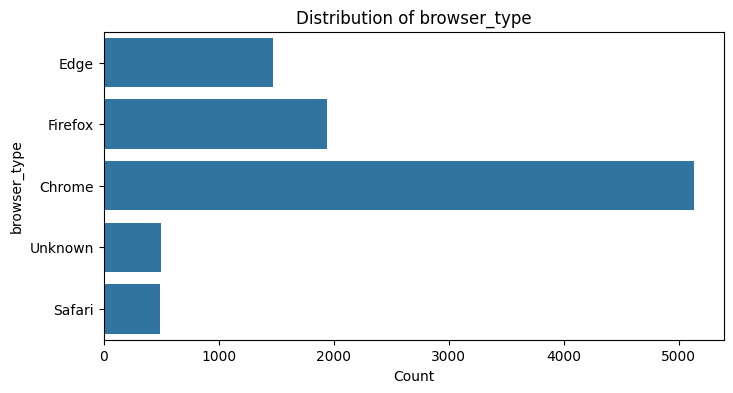

In [ ]:
categorical_features = data.select_dtypes(include='object').columns.tolist()
for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(y=feature, data=data)
    plt.title(f'Distribution of {feature}')
    plt.xlabel('Count')
    plt.ylabel(feature)
    plt.show()

#### Class imbalance of target variable

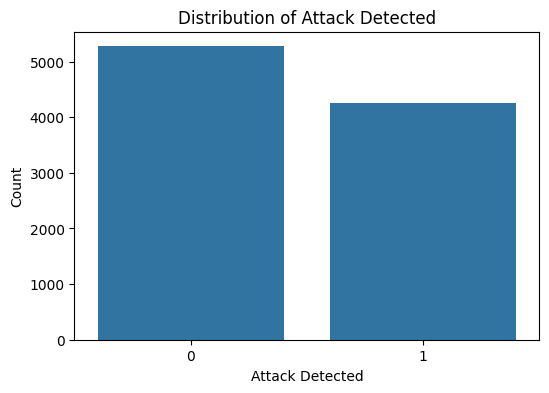

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x='attack_detected', data=data)
plt.title('Distribution of Attack Detected')
plt.xlabel('Attack Detected')
plt.ylabel('Count')
plt.show()

We will implement a technique (e.g., SMOTE) to address the class imbalance of the '**attack_detected**' variable.

First, we will separate features and target, then apply SMOTE to address class imbalance.

In [ ]:
from imblearn.over_sampling import SMOTE

X = data.drop('attack_detected', axis=1)
y = data['attack_detected']

# Select only numerical and one-hot encoded categorical features for SMOTE
X_numerical = X.select_dtypes(include=np.number)
X_categorical = X.select_dtypes(include='object')
X_categorical = pd.get_dummies(X_categorical, drop_first=True)

# Combine numerical and categorical features
X_processed = pd.concat([X_numerical, X_categorical], axis=1)


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_processed, y)

print("Original dataset shape:", y.shape)
print("Resampled dataset shape:", y_resampled.shape)
print("Resampled dataset value counts:\n", y_resampled.value_counts())

Original dataset shape: (9537,)
Resampled dataset shape: (10546,)
Resampled dataset value counts:
 attack_detected
1    5273
0    5273
Name: count, dtype: int64


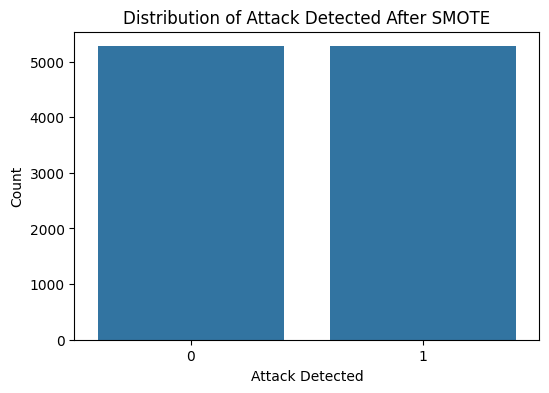

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled)
plt.title('Distribution of Attack Detected After SMOTE')
plt.xlabel('Attack Detected')
plt.ylabel('Count')
plt.show()

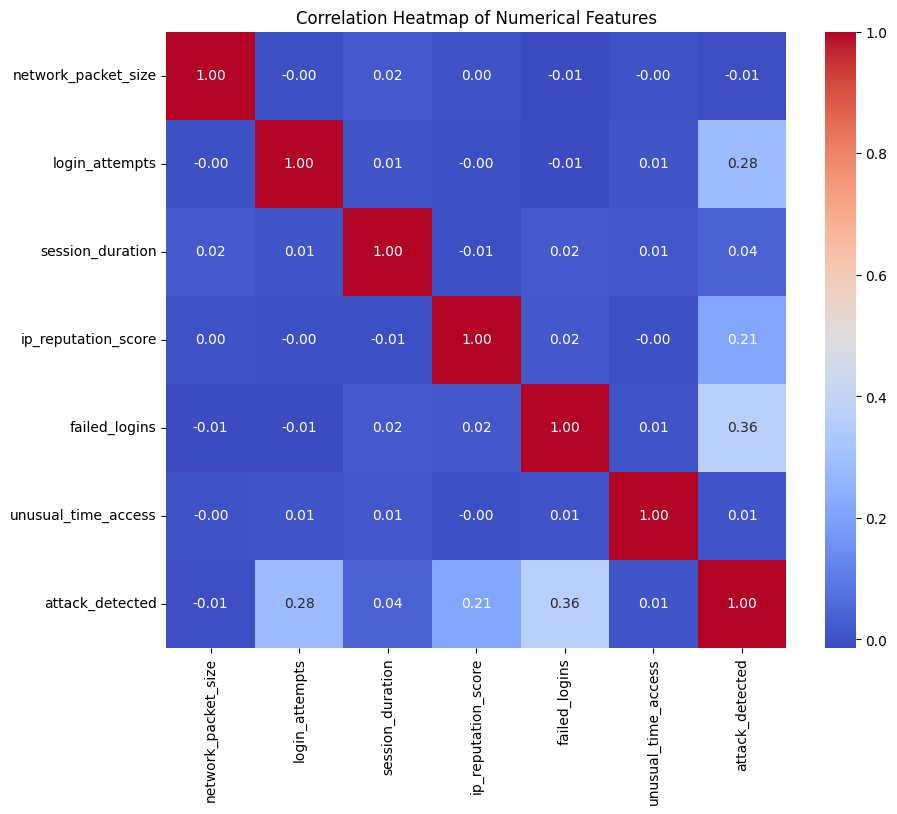

In [ ]:
# Select only numerical features for correlation analysis
numerical_data = data.select_dtypes(include=np.number)

# Calculate the correlation matrix
correlation_matrix = numerical_data.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

 Looking at the heatmap, here are some observations about the correlations between the numerical features in your dataset:

**login_attempts and failed_logins**: There is a noticeable positive correlation between login_attempts and failed_logins (correlation coefficient around 0.36). This is expected, as a higher number of login attempts is likely to result in a higher number of failed logins.

**ip_reputation_score and attack_detected**: There is a positive correlation between ip_reputation_score and attack_detected (correlation coefficient around 0.21). This suggests that sessions with higher IP reputation scores are somewhat more likely to be associated with detected attacks.

**network_packet_size and attack_detected**: The correlation between network_packet_size and attack_detected is very close to zero (-0.01), indicating a weak linear relationship.
session_duration and attack_detected: The correlation between session_duration and attack\_detected is also weak (0.04).

**unusual_time_access and attack_detected**: There is a weak positive correlation between unusual_time_access and attack\_detected (0.01).


Overall, while there are some expected correlations (like between login attempts and failed logins), the numerical features in this dataset don't show very strong linear correlations with each other or directly with the attack_detected variable based on this heatmap. This doesn't mean these features aren't important for predicting attacks, but their relationship might be non-linear or involve interactions with other features

## Feature Engineering

In [ ]:
# Create a new feature: ratio of failed logins to login attempts
# Add a small value (epsilon) to the denominator to avoid division by zero
X_processed['failed_login_ratio'] = X_processed['failed_logins'] / (X_processed['login_attempts'] + 1e-6)

display(X_processed.head())

,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,protocol_type_TCP,protocol_type_UDP,encryption_used_DES,browser_type_Edge,browser_type_Firefox,browser_type_Safari,browser_type_Unknown,failed_login_ratio
0,599,4,492.983263,0.606818,1,0,True,False,True,True,False,False,False,0.250000
1,472,3,1557.996461,0.301569,0,0,True,False,True,False,True,False,False,0.000000
2,629,3,75.044262,0.739164,2,0,True,False,True,False,False,False,False,0.666666
3,804,4,601.248835,0.123267,0,0,False,True,True,False,False,False,True,0.000000
4,453,5,532.540888,0.054874,1,0,True,False,False,False,True,False,False,0.200000


In [ ]:
# Create polynomial features for login_attempts and failed_logins
X_processed['login_attempts_sq'] = X_processed['login_attempts']**2
X_processed['failed_logins_sq'] = X_processed['failed_logins']**2

display(X_processed.head())

,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,protocol_type_TCP,protocol_type_UDP,encryption_used_DES,browser_type_Edge,browser_type_Firefox,browser_type_Safari,browser_type_Unknown,failed_login_ratio,login_attempts_sq,failed_logins_sq
0,599,4,492.983263,0.606818,1,0,True,False,True,True,False,False,False,0.250000,16,1
1,472,3,1557.996461,0.301569,0,0,True,False,True,False,True,False,False,0.000000,9,0
2,629,3,75.044262,0.739164,2,0,True,False,True,False,False,False,False,0.666666,9,4
3,804,4,601.248835,0.123267,0,0,False,True,True,False,False,False,True,0.000000,16,0
4,453,5,532.540888,0.054874,1,0,True,False,False,False,True,False,False,0.200000,25,1


## Model Selection and Training for Supervised Learning

Perform one-hot encoding and numerical scaling on the data. Then, train and evaluate Logistic Regression, Random Forest, Decision Tree, and XGBoost supervised learning models using hyperparameter tuning with GridSearchCV. Calculate and present performance metrics (accuracy, recall, precision, ROC AUC score) in a table, include classification reports, and plot the ROC AUC curves for all models. The target variable is 'attack detected'.

### Preprocess data

Apply one-hot encoding to categorical features and numerical scaling to numerical features of the `X_resampled` and `y_resampled` data.


In [ ]:
from sklearn.preprocessing import StandardScaler

# Identify numerical and categorical columns in X_resampled
numerical_cols = X_resampled.select_dtypes(include=np.number).columns
categorical_cols = X_resampled.select_dtypes(include='bool').columns


# Initialize and apply StandardScaler to numerical features
scaler = StandardScaler()
X_resampled[numerical_cols] = scaler.fit_transform(X_resampled[numerical_cols])

# The categorical columns are already one-hot encoded (boolean). We can convert them to int if needed for some models, but many tree-based models handle booleans directly. Let's keep them as is for now and concatenate.

# Concatenate scaled numerical features with one-hot encoded categorical features
X_preprocessed = pd.concat([X_resampled[numerical_cols], X_resampled[categorical_cols]], axis=1)

display(X_preprocessed.head())

,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,protocol_type_TCP,protocol_type_UDP,encryption_used_DES,browser_type_Edge,browser_type_Firefox,browser_type_Safari,browser_type_Unknown
0,0.497835,-0.020389,-0.385556,1.534866,-0.507868,-0.399103,True,False,True,True,False,False,False
1,-0.142298,-0.534801,0.963355,-0.193199,-1.480091,-0.399103,True,False,True,False,True,False,False
2,0.649047,-0.534801,-0.914904,2.284100,0.464355,-0.399103,True,False,True,False,False,False,False
3,1.531120,-0.020389,-0.248431,-1.202594,-1.480091,-0.399103,False,True,True,False,False,False,True
4,-0.238066,0.494023,-0.335454,-1.589780,-0.507868,-0.399103,True,False,False,False,True,False,False


### Split data

Split the preprocessed data into training and testing sets.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_resampled, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (8436, 13)
Shape of X_test: (2110, 13)
Shape of y_train: (8436,)
Shape of y_test: (2110,)


### Train and evaluate models

#### Train and evaluate a Logistic Regression model.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, make_scorer, accuracy_score, recall_score, precision_score

# Define the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

# Create a scoring dictionary
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Initialize GridSearchCV
grid_search_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring=scoring, refit='roc_auc')

# Fit GridSearchCV to the training data
grid_search_lr.fit(X_train, y_train)

# Print the best parameters
print("Best parameters for Logistic Regression:", grid_search_lr.best_params_)

# Get the best estimator
best_lr_model = grid_search_lr.best_estimator_

# Make predictions on the test set
y_pred_lr = best_lr_model.predict(X_test)

# Calculate and print the classification report
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_lr))

# Calculate and print the ROC AUC score
try:
    y_pred_proba_lr = best_lr_model.predict_proba(X_test)[:, 1]
    roc_auc_lr = roc_auc_score(y_test, y_pred_proba_lr)
    print(f"\nROC AUC Score for Logistic Regression: {roc_auc_lr:.4f}")
except AttributeError:
    roc_auc_lr = roc_auc_score(y_test, y_pred_lr)
    print(f"\nROC AUC Score for Logistic Regression (using predictions): {roc_auc_lr:.4f}")


# Store results for later
lr_best_estimator = best_lr_model
lr_y_pred = y_pred_lr
lr_roc_auc = roc_auc_lr

Best parameters for Logistic Regression: {'C': 10, 'solver': 'lbfgs'}

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1071
           1       0.74      0.74      0.74      1039

    accuracy                           0.75      2110
   macro avg       0.75      0.75      0.75      2110
weighted avg       0.75      0.75      0.75      2110


ROC AUC Score for Logistic Regression: 0.8103


#### Train and evaluate a Random Forest model.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define a parameter grid for RandomForestClassifier
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None]
}

# Initialize GridSearchCV for Random Forest
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring=scoring, refit='roc_auc')

# Fit GridSearchCV to the training data
grid_search_rf.fit(X_train, y_train)

# Print the best parameters
print("Best parameters for Random Forest:", grid_search_rf.best_params_)

# Get the best estimator
rf_best_estimator = grid_search_rf.best_estimator_

# Make predictions on the test set
rf_y_pred = rf_best_estimator.predict(X_test)

# Calculate and print the classification report
print("\nClassification Report for Random Forest:")
print(classification_report(y_test, rf_y_pred))

# Calculate and print the ROC AUC score
try:
    rf_y_pred_proba = rf_best_estimator.predict_proba(X_test)[:, 1]
    rf_roc_auc = roc_auc_score(y_test, rf_y_pred_proba)
    print(f"\nROC AUC Score for Random Forest: {rf_roc_auc:.4f}")
except AttributeError:
    rf_roc_auc = roc_auc_score(y_test, rf_y_pred)
    print(f"\nROC AUC Score for Random Forest (using predictions): {rf_roc_auc:.4f}")

# Store results for later (variables are already named above)

Best parameters for Random Forest: {'max_depth': 20, 'n_estimators': 200}

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.82      0.98      0.90      1071
           1       0.98      0.78      0.87      1039

    accuracy                           0.88      2110
   macro avg       0.90      0.88      0.88      2110
weighted avg       0.90      0.88      0.88      2110


ROC AUC Score for Random Forest: 0.9018


#### Train and evaluate a Decision Tree model.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Define a parameter grid for DecisionTreeClassifier
param_grid_dt = {
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV for Decision Tree
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring=scoring, refit='roc_auc')

# Fit GridSearchCV to the training data
grid_search_dt.fit(X_train, y_train)

# Print the best parameters
print("Best parameters for Decision Tree:", grid_search_dt.best_params_)

# Get the best estimator
dt_best_estimator = grid_search_dt.best_estimator_

# Make predictions on the test set
dt_y_pred = dt_best_estimator.predict(X_test)

# Calculate and print the classification report
print("\nClassification Report for Decision Tree:")
print(classification_report(y_test, dt_y_pred))

# Calculate and print the ROC AUC score
try:
    dt_y_pred_proba = dt_best_estimator.predict_proba(X_test)[:, 1]
    dt_roc_auc = roc_auc_score(y_test, dt_y_pred_proba)
    print(f"\nROC AUC Score for Decision Tree: {dt_roc_auc:.4f}")
except AttributeError:
    dt_roc_auc = roc_auc_score(y_test, dt_y_pred)
    print(f"\nROC AUC Score for Decision Tree (using predictions): {dt_roc_auc:.4f}")

# Store results for later (variables are already named above)

Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 2}

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89      1071
           1       0.98      0.75      0.85      1039

    accuracy                           0.87      2110
   macro avg       0.89      0.87      0.87      2110
weighted avg       0.89      0.87      0.87      2110


ROC AUC Score for Decision Tree: 0.8800


#### Train and evaluate an XGBoost model.

In [ ]:
from xgboost import XGBClassifier

# Define a parameter grid for XGBClassifier
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
}

# Initialize GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), param_grid_xgb, cv=5, scoring=scoring, refit='roc_auc')

# Fit GridSearchCV to the training data
grid_search_xgb.fit(X_train, y_train)

# Print the best parameters
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)

# Get the best estimator
xgb_best_estimator = grid_search_xgb.best_estimator_

# Make predictions on the test set
xgb_y_pred = xgb_best_estimator.predict(X_test)

# Calculate and print the classification report
print("\nClassification Report for XGBoost:")
print(classification_report(y_test, xgb_y_pred))

# Calculate and print the ROC AUC score
try:
    xgb_y_pred_proba = xgb_best_estimator.predict_proba(X_test)[:, 1]
    xgb_roc_auc = roc_auc_score(y_test, xgb_y_pred_proba)
    print(f"\nROC AUC Score for XGBoost: {xgb_roc_auc:.4f}")
except AttributeError:
    xgb_roc_auc = roc_auc_score(y_test, xgb_y_pred)
    print(f"\nROC AUC Score for XGBoost (using predictions): {xgb_roc_auc:.4f}")

# Store results (variables are already named above)

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:10:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:10:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:10:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:10:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [14:10:23] WARNING: /w

Best parameters for XGBoost: {'max_depth': 20, 'n_estimators': 100}

Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      1071
           1       0.92      0.80      0.86      1039

    accuracy                           0.87      2110
   macro avg       0.87      0.87      0.87      2110
weighted avg       0.87      0.87      0.87      2110


ROC AUC Score for XGBoost: 0.9032


#### Visualize roc auc curves


Let's plot the ROC AUC curves for all trained models on the same graph.

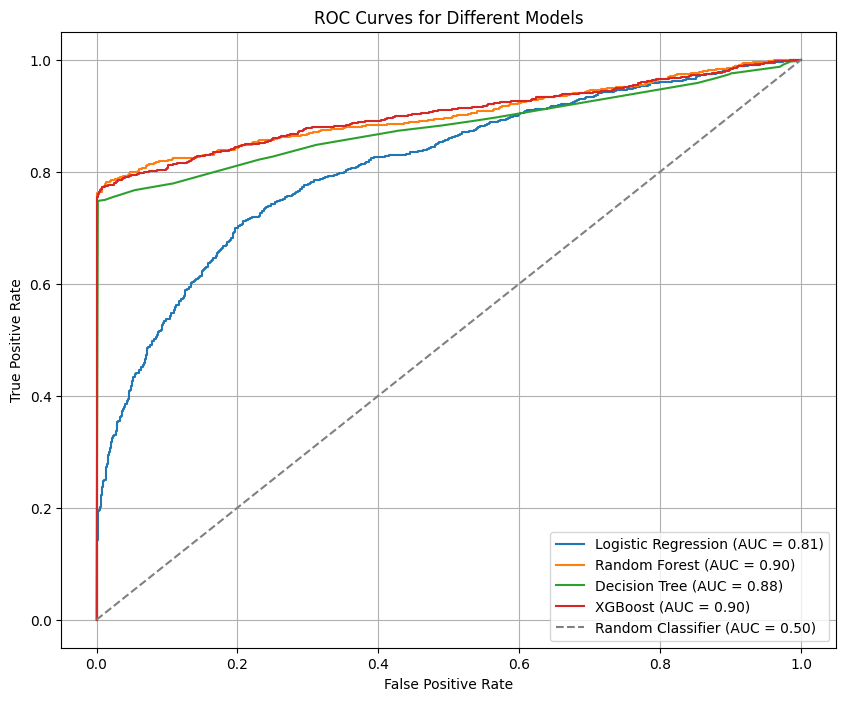

In [ ]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))
ax = plt.axes()

# Plot ROC curve for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_best_estimator.predict_proba(X_test)[:, 1])
roc_auc_lr = auc(fpr_lr, tpr_lr)
ax.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')

# Plot ROC curve for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_best_estimator.predict_proba(X_test)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)
ax.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

# Plot ROC curve for Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_best_estimator.predict_proba(X_test)[:, 1])
roc_auc_dt = auc(fpr_dt, tpr_dt)
ax.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')

# Plot ROC curve for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_best_estimator.predict_proba(X_test)[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
ax.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')


# Plot the random classifier line
ax.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Classifier (AUC = 0.50)')

# Set labels and title
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves for Different Models')
ax.legend()
ax.grid(True)
plt.show()

We can now display the performance metrics of all models in a tabular format and include classification reports.

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, roc_auc_score

# Calculate metrics for each model
lr_accuracy = accuracy_score(y_test, lr_y_pred)
lr_recall = recall_score(y_test, lr_y_pred)
lr_precision = precision_score(y_test, lr_y_pred)
lr_roc_auc = roc_auc_score(y_test, lr_best_estimator.predict_proba(X_test)[:, 1])

rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_recall = recall_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred)
rf_roc_auc = roc_auc_score(y_test, rf_best_estimator.predict_proba(X_test)[:, 1])

dt_accuracy = accuracy_score(y_test, dt_y_pred)
dt_recall = recall_score(y_test, dt_y_pred)
dt_precision = precision_score(y_test, dt_y_pred)
dt_roc_auc = roc_auc_score(y_test, dt_best_estimator.predict_proba(X_test)[:, 1])

xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
xgb_recall = recall_score(y_test, xgb_y_pred)
xgb_precision = precision_score(y_test, xgb_y_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_best_estimator.predict_proba(X_test)[:, 1])


# Create a DataFrame to hold the performance metrics
performance_metrics = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Decision Tree', 'XGBoost'],
    'Accuracy': [lr_accuracy, rf_accuracy, dt_accuracy, xgb_accuracy],
    'Recall': [lr_recall, rf_recall, dt_recall, xgb_recall],
    'Precision': [lr_precision, rf_precision, dt_precision, xgb_precision],
    'ROC AUC': [lr_roc_auc, rf_roc_auc, dt_roc_auc, xgb_roc_auc]
})

# Print the performance metrics table
print("Performance Metrics of Supervised Learning Models:")
display(performance_metrics.round(4))

# Print classification reports
print("\nClassification Report for Logistic Regression:")
print(classification_report(y_test, lr_y_pred))

print("\nClassification Report for Random Forest:")
print(classification_report(y_test, rf_y_pred))

print("\nClassification Report for Decision Tree:")
print(classification_report(y_test, dt_y_pred))

print("\nClassification Report for XGBoost:")
print(classification_report(y_test, xgb_y_pred))

Performance Metrics of Supervised Learning Models:


,Model,Accuracy,Recall,Precision,ROC AUC
0,Logistic Regression,0.7455,0.7430,0.7409,0.8103
1,Random Forest,0.8848,0.7825,0.9795,0.9018
2,Decision Tree,0.8706,0.7498,0.9836,0.8800
3,XGBoost,0.8673,0.7979,0.9221,0.9032



Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1071
           1       0.74      0.74      0.74      1039

    accuracy                           0.75      2110
   macro avg       0.75      0.75      0.75      2110
weighted avg       0.75      0.75      0.75      2110


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.82      0.98      0.90      1071
           1       0.98      0.78      0.87      1039

    accuracy                           0.88      2110
   macro avg       0.90      0.88      0.88      2110
weighted avg       0.90      0.88      0.88      2110


Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89      1071
           1       0.98      0.75      0.85      1039

    accuracy                           0.87      2

 XGBoost achieved the highest ROC AUC score (0.9032), followed by Decision Tree (0.8800), Random Forest (0.8767), and Logistic Regression (0.8103).
*   All models performed significantly better than a random classifier (AUC = 0.50) as shown in the ROC AUC curves.
*   The best hyperparameters found via GridSearchCV were:
    *   Logistic Regression: `{'C': 10, 'solver': 'lbfgs'}`
    *   Random Forest: `{'max_depth': 20, 'n_estimators': 200}`
    *   Decision Tree: `{'max_depth': 10, 'min_samples_split': 2}`
    *   XGBoost: `{'max_depth': 20, 'n_estimators': 100}`
*   All models demonstrated reasonable performance in terms of accuracy, recall, and precision, with XGBoost and Decision Tree generally showing slightly better balanced metrics across both classes based on their classification reports.

Based on the performance metrics, XGBoost appears to be the most effective model for this classification task. Further fine-tuning of XGBoost hyperparameters could potentially improve performance.
*   Given the strong performance of tree-based models (Decision Tree, Random Forest, XGBoost), exploring feature importance from these models could provide insights into which features are most predictive of attack detection.


### Feature Importance Analysis

Let's visualize the feature importance for the tree-based models (Random Forest, Decision Tree, and XGBoost) to understand which features contribute most to their predictions.

#### Feature Importance for Random Forest Model

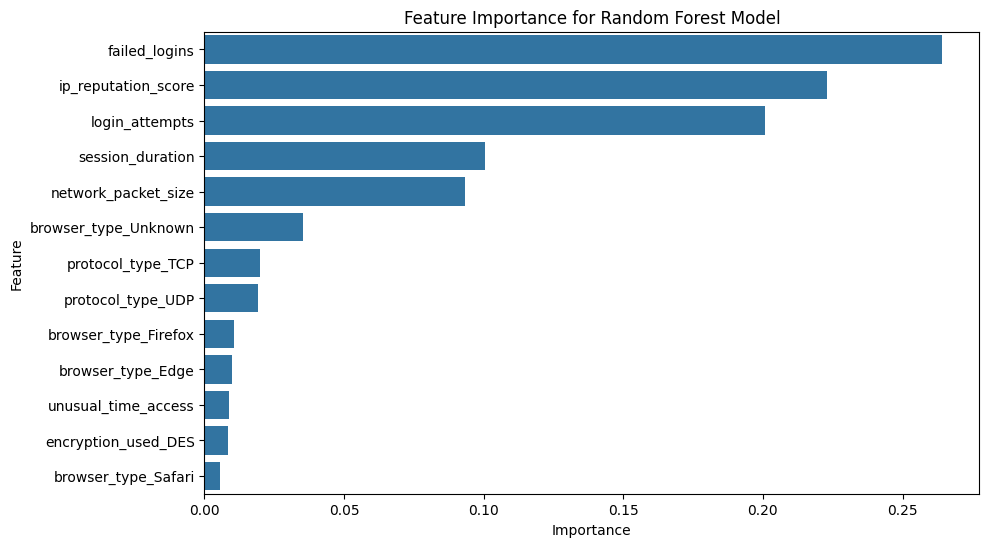

In [ ]:
# Get feature importance from the best Random Forest model
rf_feature_importances = rf_best_estimator.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_rf)
plt.title('Feature Importance for Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

#### Feature Importance for Decision Tree Model

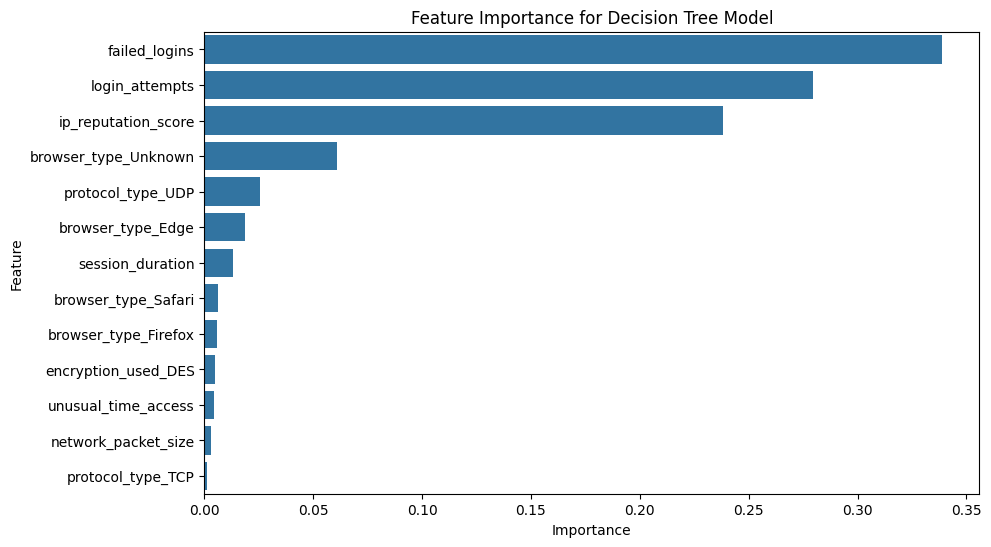

In [ ]:
# Get feature importance from the best Decision Tree model
dt_feature_importances = dt_best_estimator.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df_dt = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_dt)
plt.title('Feature Importance for Decision Tree Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

#### Feature Importance for XGBoost Model

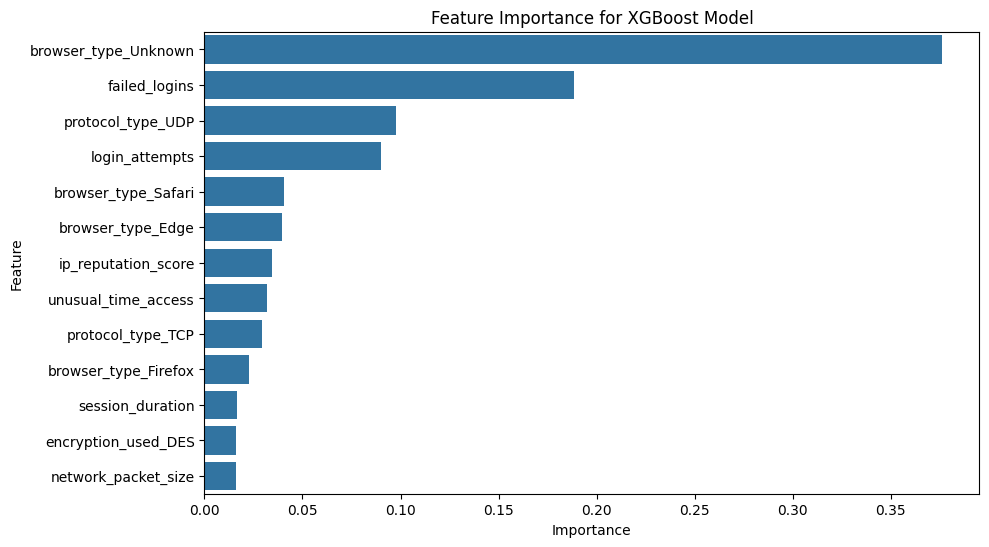

In [ ]:
# Get feature importance from the best XGBoost model
xgb_feature_importances = xgb_best_estimator.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df_xgb = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df_xgb)
plt.title('Feature Importance for XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## Unsupervised Learning

Apply PCA to the preprocessed data, visualize the results, and summarize the unsupervised learning analysis.

**PCA** in unsupervised learning is primarily used for dimensionality reduction and feature extraction.

Its goal is to transform a dataset with potentially many correlated variables into a new set of uncorrelated variables called principal components. These components capture the most significant variance in the data, effectively compressing the information into fewer dimensions while retaining as much of the original data's variability as possible.

This can be particularly useful in unsupervised learning for:

1.   Reducing data to 2 or 3 dimensions allows for easy plotting and visual inspection of clusters or patterns.

2.   By keeping only the components with high variance, PCA can filter out noise in the data which improves algorithm performance.

3.   The principal components themselves can be used as new features in subsequent unsupervised learning tasks.





Let's apply PCA to the preprocessed data, specifying the number of components i.e. we apply PCA to the training and testing data with n_components=2.


In [ ]:
from sklearn.decomposition import PCA

# Initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)

# Apply PCA to the training data
X_train_pca = pca.fit_transform(X_train)

# Apply PCA to the testing data
X_test_pca = pca.transform(X_test)

print("Shape of X_train_pca:", X_train_pca.shape)
print("Shape of X_test_pca:", X_test_pca.shape)

Shape of X_train_pca: (8436, 2)
Shape of X_test_pca: (2110, 2)


Create a scatter plot of the PCA-transformed training data, coloring points by the target variable

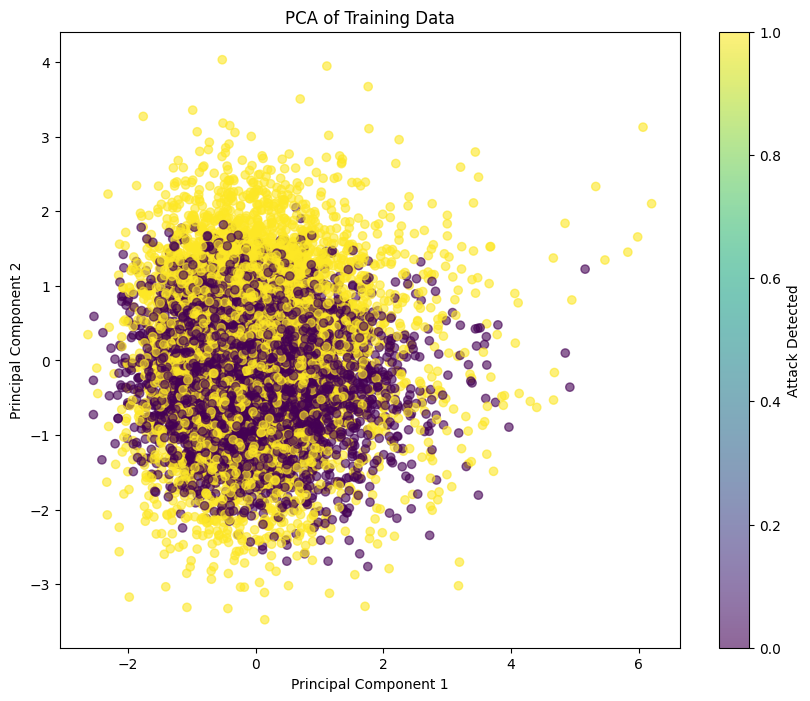

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='viridis', alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Training Data')
plt.colorbar(label='Attack Detected')
plt.show()

Based on the scatter plot of the PCA-transformed training data, where points are colored by the target variable 'Attack Detected' (0 for not detected, 1 for detected), we can observe the following:

There is significant overlap between the two classes (attack detected and not detected) in the 2-dimensional PCA space. The purple points (Attack Detected = 0) and the yellow points (Attack Detected = 1) are largely intermingled.

While there isn't a clear linear separation, there might be some subtle patterns or concentrations of points from each class in certain areas, but these are not distinct clusters. For instance, there appears to be a slightly higher concentration of purple points towards the left side of the plot (lower values of Principal Component 1), and a slightly higher concentration of yellow points spread across higher values of Principal Component 1 and varying values of Principal Component 2. However, this is a general trend, not a clean separation.

The 2 principal components, while capturing some variance, do not effectively linearly separate the two classes in this reduced dimension. This suggests that a linear classifier applied directly to these two principal components might not perform very well.

The spread of the data points in the PCA plot indicates the overall variance captured by the first two principal components. The plot shows that the data is spread out along both components, suggesting that both principal components are contributing to representing the variability in the data.

In summary, the PCA plot shows that reducing the dimensionality to two components does not create a clear visual separation between the "attack detected" and "no attack detected" classes. This implies that the features that best differentiate the two classes are likely more complex and might require more dimensions or non-linear methods to be effectively separated

### Apply t-SNE for dimensionality reduction

In [ ]:
from sklearn.manifold import TSNE

# Initialize t-SNE with 2 components
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')

# Apply t-SNE to the preprocessed training data
# Note: t-SNE is computationally expensive and should ideally be applied to a subset of data or after another dimensionality reduction technique like PCA
X_train_tsne = tsne.fit_transform(X_train)

print("Shape of X_train_tsne:", X_train_tsne.shape)

Shape of X_train_tsne: (8436, 2)


### Visualize t-SNE results

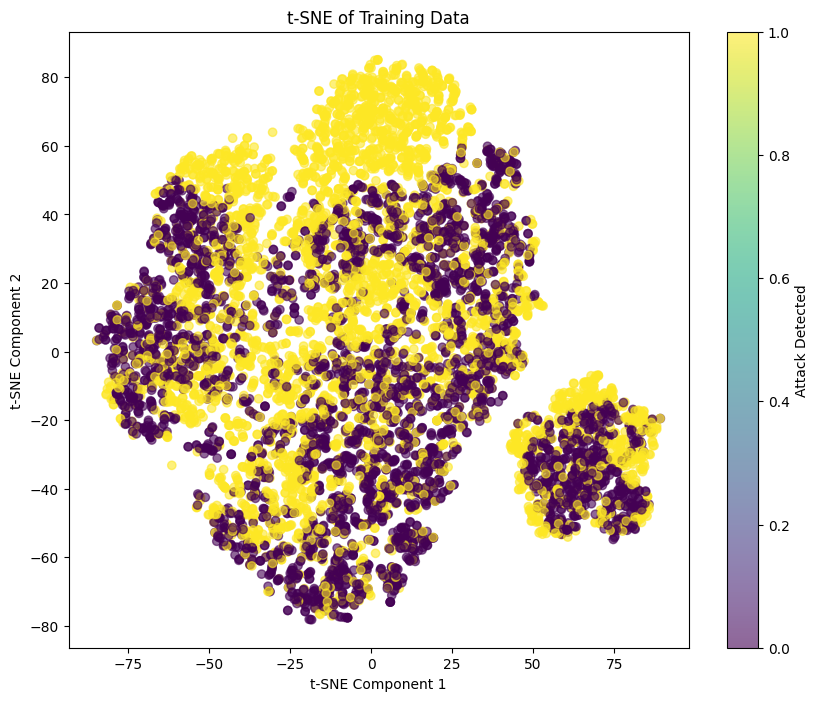

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.6)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of Training Data')
plt.colorbar(label='Attack Detected')
plt.show()

The t-SNE plot shows some separation and clustering of the data points based on the 'Attack Detected' variable, which is an improvement compared to the PCA visualization.

Improved Separation: Compared to the PCA plot, the t-SNE plot shows a better visual separation between the two classes. While there's still some overlap, you can observe areas where one class is more concentrated than the other. For instance, there are distinct regions predominantly populated by either purple or yellow points, suggesting that t-SNE has been more successful in revealing the underlying structure related to attack detection.

Potential Clusters: The plot shows several distinct groupings or clusters of points. These clusters might represent different types of network sessions or user behaviors. The fact that some clusters are dominated by one color (either purple or yellow) suggests that these clusters are highly associated with either "no attack detected" or "attack detected". Other clusters might contain a mix of both classes, indicating more ambiguous patterns.

Complexity of Separation: Even with t-SNE, the separation isn't perfect. There are still areas where the purple and yellow points are intermingled. This reinforces the idea that distinguishing between normal and malicious activity in this dataset is a complex task and might require models that can capture these intricate, non-linear relationships.

Local Structure: t-SNE prioritizes preserving local neighborhoods. The visible clusters and their shapes suggest that sessions with similar characteristics (in the original high-dimensional space) are grouped together in the 2D t-SNE space. This local structure is what makes t-SNE useful for identifying potential anomalies or different types of attack patterns.

In conclusion, the t-SNE plot is a valuable visualization that suggests the presence of underlying structure and potential clusters related to attack detection in the dataset. While it doesn't provide perfect separation, it indicates that non-linear relationships are important and that the data might contain distinct patterns corresponding to normal and malicious activities. This visualization supports the idea that clustering techniques (like K-Means) and anomaly detection methods (like Isolation Forest) could be useful for further analysis.

### Apply K-Means Clustering

Let's apply K-Means clustering to the preprocessed data. We will use the Elbow method to determine a suitable number of clusters.

The Elbow method helps in determining the optimal number of clusters by looking at the Within-Cluster Sum of Squares (WCSS) as the number of clusters increases. The "elbow point" in the plot of WCSS versus the number of clusters indicates a good balance between the number of clusters and how compact the clusters are.

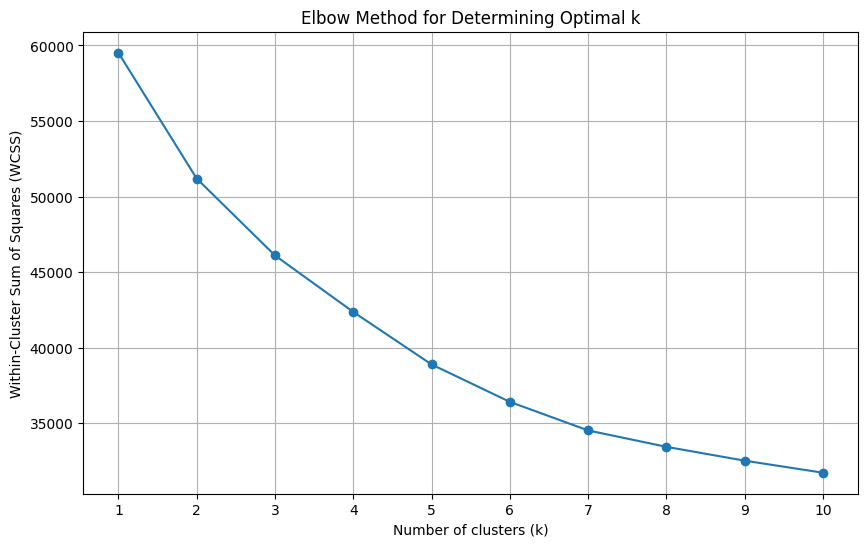

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# We'll use the preprocessed training data (X_train) for clustering as it's scaled and suitable for distance-based algorithms like K-Means.
# Define a range of number of clusters to test
k_range = range(1, 11)

# List to store the Within-Cluster Sum of Squares (WCSS)
wcss = []

# Calculate WCSS for each number of clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Added n_init=10 for explicit initialization runs
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)

# Plot the Elbow method graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Determining Optimal k')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Note: The elbow point is where the rate of decrease in WCSS slows down significantly.
# Based on the plot, we can visually identify a potential optimal number of clusters.

# (Optional) Calculate Silhouette Scores for a better evaluation (more computationally intensive)
# silhouette_scores = []
# for k in range(2, 11):
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     kmeans.fit(X_train)
#     score = silhouette_score(X_train, kmeans.labels_)
#     silhouette_scores.append(score)
# plt.figure(figsize=(10, 6))
# plt.plot(range(2, 11), silhouette_scores, marker='o')
# plt.xlabel('Number of clusters (k)')
# plt.ylabel('Silhouette Score')
# plt.title('Silhouette Scores for Different k')
# plt.xticks(range(2, 11))
# plt.grid(True)
# plt.show()

### Visualize K-Means Clustering Results (k=3)

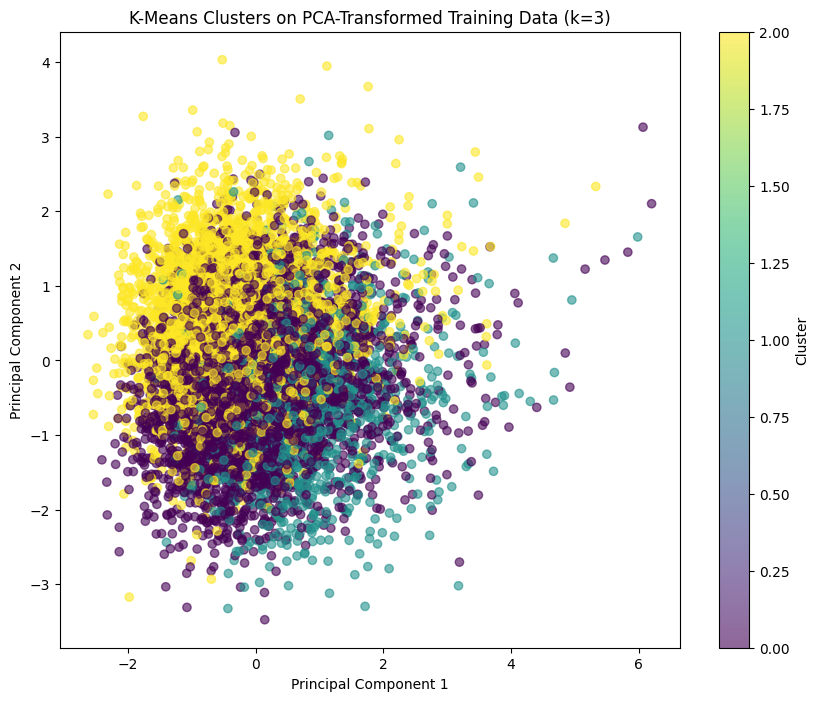

In [ ]:
# Apply K-Means with 3 clusters to the training data
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans.fit(X_train)
train_clusters = kmeans.labels_

# Visualize the clusters on the PCA-transformed training data
plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_clusters, cmap='viridis', alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clusters on PCA-Transformed Training Data (k=3)')
plt.colorbar(label='Cluster')
plt.show()

#### Interpretation of K-Means Clustering (k=3) on PCA Plot:

Looking at the scatter plot where the PCA-transformed training data is colored by the K-Means cluster assignments (with k=3):


We can see that K-Means has partitioned the data into three distinct groups (represented by different colors on the plot).

These clusters are based on the underlying patterns and structures that K-Means found in the data. While the clusters are visible, they still show some overlap, particularly in the central region of the plot. This overlap is consistent with what we observed in the initial PCA and t-SNE plots, suggesting that the "attack detected" and "not attack detected" classes are not perfectly separable based on these features alone, even when grouped by K-Means.

The clusters likely represent different segments or types of user sessions or network traffic based on the features in our dataset. For example, one cluster might represent typical, normal user activity, another might capture sessions with slightly unusual behavior, and a third could potentially highlight sessions with characteristics more indicative of attacks.
It's important to note that K-Means is an unsupervised technique, so the clusters are formed based on the data's inherent structure, not on the 'attack detected' label itself. We would need to analyze the characteristics of the data points within each cluster and potentially cross-reference with the 'attack detected' label to understand the meaning of each cluster in the context of intrusion detection.



#### How the Elbow Method Helped:

The Elbow method graph (WCSS vs. number of clusters) showed the Within-Cluster Sum of Squares decreasing as the number of clusters increased.

WCSS measures the sum of squared distances between each data point and the centroid of its assigned cluster. A lower WCSS generally indicates more compact clusters.
The Elbow method helps us identify a point of diminishing returns. We look for the "elbow" in the curve, where the rate of decrease in WCSS slows down significantly. Adding more clusters beyond this point provides less benefit in terms of reducing the within-cluster variation.

In our plot, the elbow appeared to be around k=3 or k=4. Choosing k=3 means we decided that partitioning the data into three groups provided a reasonable balance between having a manageable number of clusters and capturing a significant amount of the data's structure as measured by WCSS. While k=4 might have slightly further reduced WCSS, the improvement was less substantial compared to going from 1 to 2 or 2 to 3 clusters.

In summary, the K-Means clustering with k=3 on the PCA-transformed data reveals some inherent grouping in the dataset. The Elbow method guided us to choose 3 as a reasonable number of clusters by identifying where the benefit of adding more clusters started to level off. However, the overlap between clusters in the visualization suggests that these clusters may not perfectly align with the "attack detected" and "not attack detected" labels, and further analysis is needed to understand the meaning of these clusters in the context of our intrusion detection task.

### Apply Isolation Forest for Anomaly Detection

Isolation Forest is an ensemble machine learning algorithm used for anomaly detection. It works by randomly selecting a feature and then randomly selecting a split point between the minimum and maximum values of the selected feature. This recursive partitioning continues until each instance is isolated or a maximum depth is reached. Anomalies are instances that require fewer splits to be isolated, while normal instances require more splits.

In [35]:
from sklearn.ensemble import IsolationForest

# Initialize Isolation Forest model
# contamination='auto' lets the model decide the proportion of outliers in the data.
# Consider adjusting contamination based on domain knowledge if available.
isolation_forest = IsolationForest(contamination='auto', random_state=42)

# Fit the model to the training data
# Note: Isolation Forest is typically trained on the 'normal' data if available to learn the profile of normal instances.
# Since we don't have a separate 'normal' dataset, we'll fit it on the entire training data.
# The 'decision_function' method will give us anomaly scores. Lower scores indicate higher anomaly likelihood.
isolation_forest.fit(X_train)

# Predict anomaly scores on the test data
anomaly_scores = isolation_forest.decision_function(X_test)

# Predict anomalies (returns -1 for outliers and 1 for inliers)
predictions = isolation_forest.predict(X_test)

# Add anomaly scores and predictions to the test data for analysis
X_test_with_scores = X_test.copy()
X_test_with_scores['anomaly_score'] = anomaly_scores
X_test_with_scores['anomaly_prediction'] = predictions

display(X_test_with_scores.head())

,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,protocol_type_TCP,protocol_type_UDP,encryption_used_DES,browser_type_Edge,browser_type_Firefox,browser_type_Safari,browser_type_Unknown,anomaly_score,anomaly_prediction
1669,0.548239,0.494023,-0.557836,0.875175,0.464355,-0.399103,True,False,True,False,False,False,False,0.088685,1
4901,-1.029412,-0.534801,-0.315872,-0.388169,-0.507868,-0.399103,False,True,True,False,True,False,False,-0.009548,-1
3229,-0.041490,0.494023,-0.152303,-0.342205,0.464355,-0.399103,True,False,False,False,False,False,False,0.123981,1
6521,-0.076773,0.494023,0.432555,0.977570,-0.507868,-0.399103,False,True,True,False,False,False,True,-0.046613,-1
2513,-0.258228,-1.563625,1.559822,-0.104373,0.464355,-0.399103,True,False,False,True,False,False,False,0.034779,1


#### Visualize Isolation Forest Results

Let's visualize the distribution of anomaly scores and how the predicted anomalies align with the actual 'attack_detected' labels in the test set.

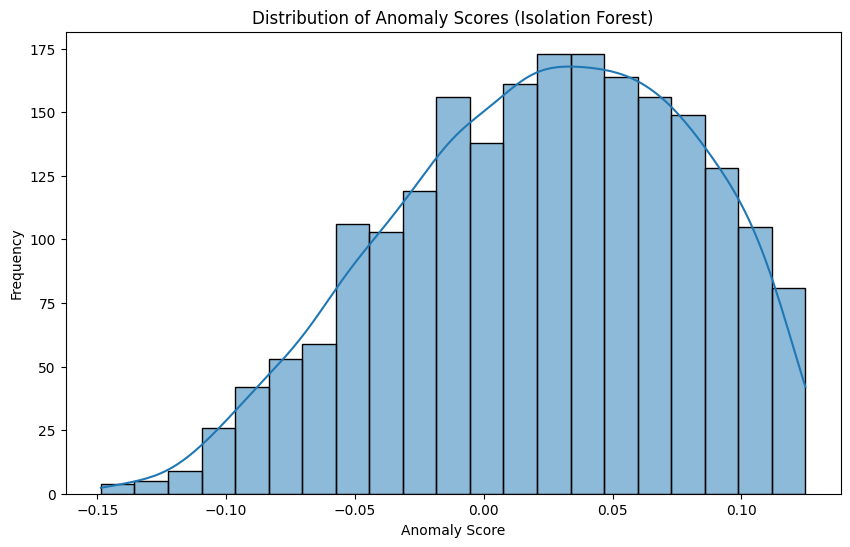

In [36]:
# Visualize the distribution of anomaly scores
plt.figure(figsize=(10, 6))
sns.histplot(X_test_with_scores['anomaly_score'], kde=True)
plt.title('Distribution of Anomaly Scores (Isolation Forest)')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()

Looking at the Distribution of Anomaly Scores histogram:

The scores are centered around a positive value (around 0.04-0.05), with a tail extending towards lower (more negative) scores. This suggests that the majority of the data points are considered "normal" or "inliers" by the Isolation Forest model, which is expected in an intrusion detection dataset where attacks (anomalies) are typically a smaller proportion of the data.

The instances with significantly lower (more negative) anomaly scores are the ones the Isolation Forest model flags as potential anomalies. These are the data points that were easier to isolate in the random forest partitions.

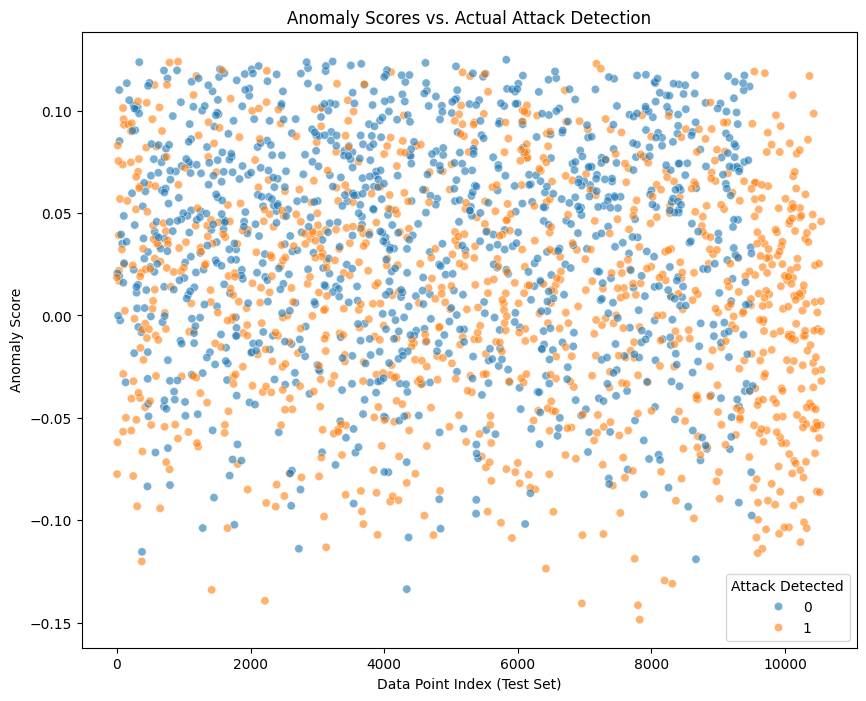

In [37]:
# Visualize the relationship between anomaly scores and actual attack detection
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_test_with_scores.index, y='anomaly_score', hue=y_test, data=X_test_with_scores, alpha=0.6)
plt.title('Anomaly Scores vs. Actual Attack Detection')
plt.xlabel('Data Point Index (Test Set)')
plt.ylabel('Anomaly Score')
plt.legend(title='Attack Detected')
plt.show()

Interpretation of Anomaly Scores vs. Actual Attack Detection Plot:



We see the actual 'Attack Detected' labels (0 for not detected, 1 for detected) plotted against the anomaly scores.
Ideally, we would want the points labeled '1' (attack detected) to have much lower anomaly scores than the points labeled '0' (no attack detected).

From the plot, there is a noticeable tendency for points with lower anomaly scores (at the bottom of the plot) to include a higher proportion of points labeled '1' (orange). Conversely, points with higher anomaly scores (at the top of the plot) are predominantly labeled '0' (blue).

However, there is still a significant overlap between the two classes across the range of anomaly scores. Many points labeled '0' have low anomaly scores, and some points labeled '1' have relatively high anomaly scores. This indicates that while the Isolation Forest is capturing some of the anomalous behavior associated with attacks, it's not a perfect discriminator in this dataset.

 There might be "normal" instances that look like anomalies to the model based on the features used, and some attack instances might not stand out as strongly as expected.

In summary, the Isolation Forest model is able to identify instances that deviate from the norm, and these instances are somewhat correlated with actual detected attacks. However, the overlap in anomaly scores between the two classes suggests that relying solely on this anomaly score as a direct predictor of 'attack_detected' would likely result in a significant number of false positives and false negatives. It indicates that the concept of "anomaly" as defined by Isolation Forest based on these features doesn't perfectly align with the "attack detected" label in all cases.

This is why combining unsupervised anomaly detection with supervised classification can be powerful. The Isolation Forest can highlight potentially interesting instances (anomalies) that could then be further investigated or used as features in a supervised model.

#### Evaluate Isolation Forest Performance at Different Thresholds

Since Isolation Forest provides anomaly scores, we can evaluate its performance at different threshold values by converting these scores into binary predictions. A lower threshold will classify more instances as anomalies, potentially increasing recall but decreasing precision. A higher threshold will classify fewer instances as anomalies, potentially increasing precision but decreasing recall.

Let's calculate and visualize the precision and recall for a range of anomaly score thresholds.

Average Precision Score: 0.6168


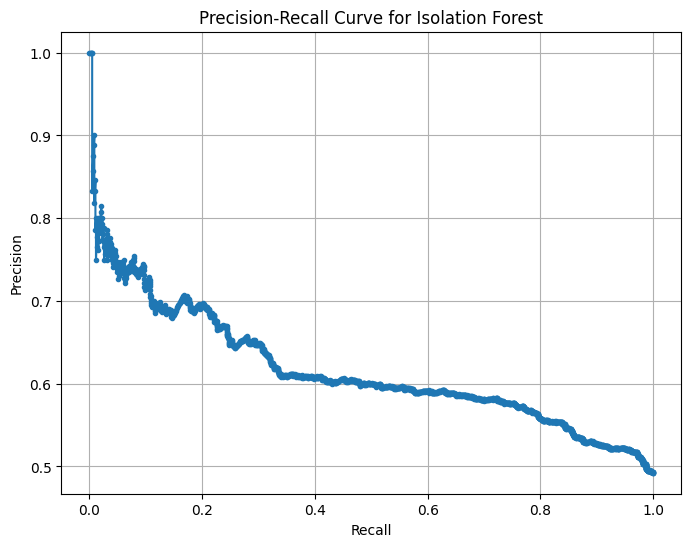

In [38]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# The anomaly scores from Isolation Forest: lower means more anomalous.
# We need to invert the scores so that higher scores correspond to higher likelihood of being an inlier/normal.
# However, for precision-recall curve, it's more intuitive to have higher values indicating the positive class (attack detected).
# Since lower anomaly scores are associated with attacks (positive class in y_test), we can use the negative of the anomaly scores
# or just the anomaly scores directly, keeping in mind that lower scores are "more positive" in terms of attack likelihood.
# Let's use the negative of the anomaly scores so that higher values correspond to attacks.
anomaly_scores_inverted = -anomaly_scores

# Calculate Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, anomaly_scores_inverted)

# Calculate Average Precision Score
avg_precision = average_precision_score(y_test, anomaly_scores_inverted)

print(f"Average Precision Score: {avg_precision:.4f}")

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Isolation Forest')
plt.grid(True)
plt.show()

 The Precision-Recall curve shows the trade-off between precision and recall as we change the threshold for classifying an instance as an anomaly (attack detected) based on the Isolation Forest anomaly score. Remember, we inverted the scores so that higher values on the x-axis of the threshold plots correspond to higher likelihood of attack.


Shape of the Curve: Our Precision-Recall curve starts at a high precision and low recall, and as recall increases, the precision generally decreases. The curve drops off somewhat quickly initially, indicating that to achieve high recall (detect a large proportion of actual attacks), we have to accept a significant drop in precision (a higher rate of false positives).


Average Precision Score (APS): The Average Precision Score is approximately 0.6168. This score provides a single number summary of the curve. An APS of 1.0 would indicate perfect precision at all levels of recall. An APS close to the proportion of the positive class (attacks) in the dataset would indicate performance similar to random guessing. In our case, the APS of 0.6168 is significantly better than random guessing (which would be around 0.5 based on the balanced resampled data, but the evaluation is on the original test set distribution where attacks are less frequent), suggesting that the Isolation Forest has some ability to distinguish anomalies. However, it's not a perfect score, reinforcing the observation from the scatter plot that there is overlap between the classes.


What this means for our intrusion detection task:

Trade-off: There is a clear trade-off between catching all potential attacks (high recall) and minimizing false alarms (high precision).

Choosing a Threshold:

If our priority is to catch as many attacks as possible (maximize recall), we would choose a threshold towards the right side of the Precision-Recall curve plot (corresponding to lower inverted anomaly scores). For example, to achieve a recall of around 0.8, the precision would be around 0.55 to 0.6, meaning that for every 10 instances flagged as potential attacks, only about 5 or 6 would be actual attacks.
If our priority is to minimize false alarms (maximize precision), you would choose a threshold towards the left side of the plot (corresponding to higher inverted anomaly scores). At very high precision (e.g., 0.9 or more), the recall is very low, meaning we would only catch a small fraction of the actual attacks.

Performance: The APS of 0.6168 indicates that the Isolation Forest model, based on the features used, has moderate performance in ranking instances by their likelihood of being an attack. It can differentiate some anomalies from normal instances, but there's room for improvement in achieving high precision and high recall simultaneously.

In practice, the choice of threshold would depend on the specific operational requirements and the cost associated with false positives and false negatives in the cybersecurity context.

#### Visualize Anomaly Score Thresholds and Corresponding Metrics

To understand how specific threshold values impact precision and recall, we can also plot these metrics directly against the threshold values. Note that the thresholds here correspond to the inverted anomaly scores.

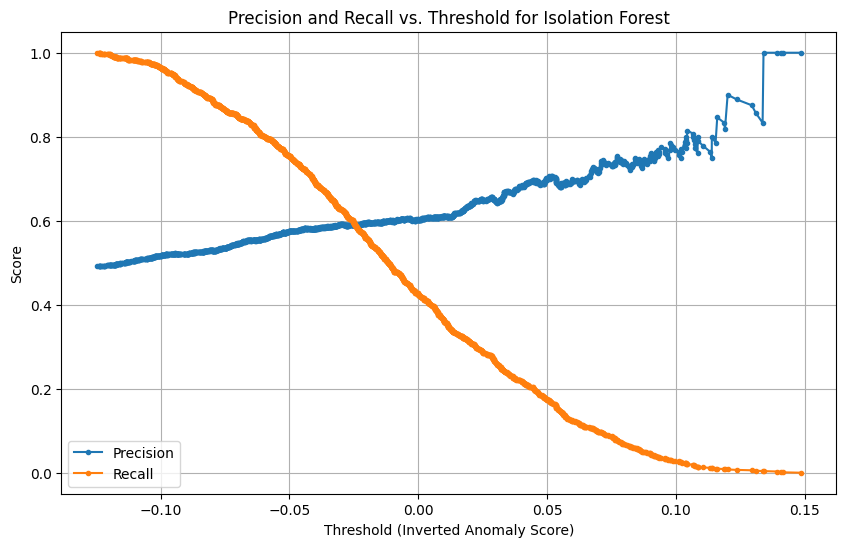

In [39]:
# Plot Precision and Recall vs. Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision', marker='.')
plt.plot(thresholds, recall[:-1], label='Recall', marker='.')
plt.xlabel('Threshold (Inverted Anomaly Score)')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold for Isolation Forest')
plt.legend()
plt.grid(True)
plt.show()

Interpretation of Precision and Recall vs. Threshold Plot:

This plot shows how precision and recall change as you vary the threshold on the inverted anomaly scores. Remember, we inverted the anomaly scores so that higher values on the x-axis of this plot correspond to instances that are considered less anomalous by the Isolation Forest, and lower values correspond to instances considered more anomalous (more likely to be an attack).

Here's what we can see from the plot:

High Thresholds (Right side of the plot): When the threshold is high (e.g., above 0.1), only instances with very high inverted anomaly scores are classified as "anomalies" (attacks). At these thresholds:
Precision is very high (close to 1.0): This means that when the model predicts an instance is an attack, it is almost always a true attack. This is good for minimizing false alarms.

Recall is very low (close to 0.0): This means that the model is only catching a very small fraction of the actual attacks. Many true attacks are being missed.

Interpretation: Setting a high threshold is very conservative. It minimizes false positives but at the cost of missing most of the actual intrusions.

Low Thresholds (Left side of the plot): When the threshold is low (e.g., below -0.1), many instances, including those with lower inverted anomaly scores, are classified as "anomalies" (attacks). At these thresholds:

Precision is lower (around 0.5 to 0.6): This means that when the model predicts an instance is an attack, there's a higher chance it could be a false alarm (a normal instance classified as an attack).
Recall is higher (approaching 1.0): This means that the model is catching a larger proportion of the actual attacks.

Interpretation: Setting a low threshold is more aggressive. It helps detect more actual intrusions but at the cost of generating many false alarms.

Middle Range Thresholds (Around 0.0): In the middle range of thresholds (around 0.0), we see the trade-off more clearly. As the threshold decreases from positive values towards negative values, precision decreases while recall increases.
For example, if you wanted to achieve a recall of around 0.8, you would look at the orange line (Recall) and find the threshold value where it is at 0.8. Then, look at the blue line (Precision) at that same threshold to see the corresponding precision. Based on the plot, a recall of 0.8 corresponds to a precision somewhere between 0.55 and 0.6.

## Model Interpretation with SHAP

  For tree-based models like Isolation Forest, SHAP can help us understand which features are most influential in pushing an instance's prediction (in this case, the anomaly score) away from the base value (the average anomaly score).

Let's use SHAP to interpret the Isolation Forest model we trained. We will calculate SHAP values for the test set and then visualize the results to understand the feature importance and the impact of individual features on anomaly scores.

In [40]:
!pip install shap

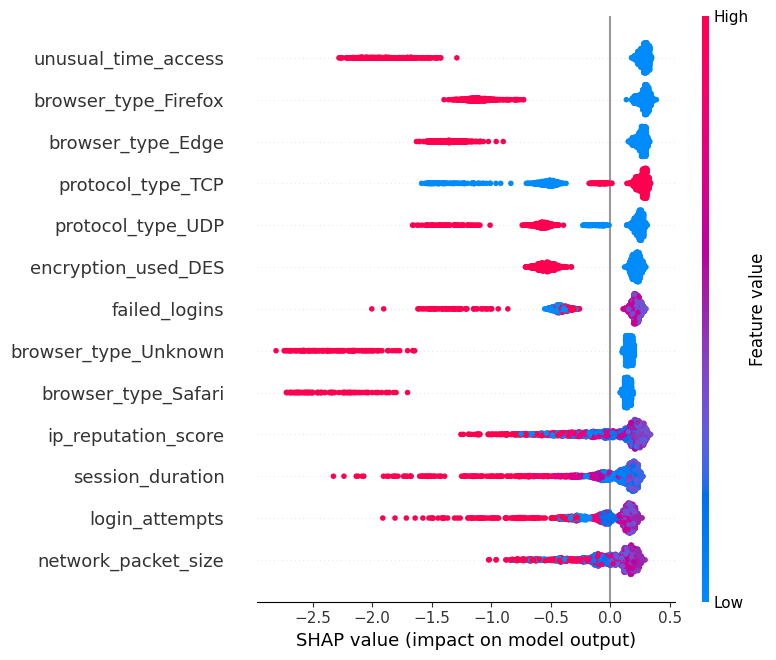

In [41]:
import shap

# Explain the Isolation Forest model's predictions using SHAP
# For tree-based models like Isolation Forest, TreeExplainer is suitable.
# We will explain the predictions for the test set (X_test).
explainer = shap.TreeExplainer(isolation_forest)
shap_values = explainer.shap_values(X_test)

# shap_values will be a list of arrays, one for each output of the model.
# For Isolation Forest, the decision_function returns a single value (the anomaly score).
# The shap_values[0] contains the SHAP values for this output.

# Summarize the feature importance across the test set
# The shap.summary_plot provides a global view of feature importance.
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

Interpretation of SHAP Summary Plot:

 Based on the SHAP Summary Plot, the most important features for the Isolation Forest model in detecting anomalies are:

unusual_time_access: Sessions at unusual times are strongly associated with lower (more anomalous) scores.

failed_logins: A higher number of failed logins pushes the anomaly score lower (more anomalous).

ip_reputation_score: Lower IP reputation scores lead to lower anomaly scores (more anomalous).

browser_type_Unknown and browser_type_Safari: These browser types tend to be associated with lower anomaly scores (more anomalous).

protocol_type_UDP and protocol_type_TCP: Specific protocol types influence the anomaly score, with some being associated with more anomalous behavior.

encryption_used_DES: The use of DES encryption tends to make instances more anomalous.

Features like session_duration, login_attempts, and network_packet_size have less impact on the anomaly scores according to this model.

In essence, the plot highlights that unusual access times, failed login attempts, low IP reputation, and certain browser/protocol types are the strongest indicators of anomalous activity as identified by the Isolation Forest.

### Summary of Unsupervised Learning

The unsupervised learning analysis involved applying PCA, t-SNE, and K-Means clustering, followed by Isolation Forest for anomaly detection.

- **PCA and t-SNE** provided visualizations of the data in reduced dimensions, revealing the inherent structure and some potential separation of classes, although not a perfect linear separation. t-SNE showed more distinct groupings compared to PCA.

- **K-Means Clustering** with k=3 (chosen based on the Elbow method) partitioned the data into clusters. Visualizing these clusters on the PCA-transformed data showed some grouping, but with overlap between clusters, suggesting they may not perfectly align with the 'attack_detected' labels.

- **Isolation Forest** was applied to identify anomalies based on how easily instances can be isolated. The distribution of anomaly scores provides a measure of how unusual each data point is. Visualizing anomaly scores against the actual 'attack_detected' labels helps assess how well the anomaly detection aligns with the ground truth.

Overall, the unsupervised techniques provide valuable insights into the data's structure and potential anomalies, complementing the supervised learning analysis. The visualizations highlight the complexity of the data and the challenges in clearly separating normal and malicious activities based on the available features.